In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=200) # Sets message printing width for easier readability

#-- Add utilityFunctions/ to easily use utility .py files --#
import os.path
from os import path
import sys
sys.path.append("utilityFunctions/")
sys.path.append("plottingUtils/")

In [2]:
#-- Boolean flags to change options --#
CONVERTPARAMS = True # Converts parameters of multinest scan to ones we would like to plot
EXPBOUNDS     = True
DEBUG         = True
PLOTRANGE     = 'BP1'

# NOTE: This notebook assumes 2d scan in fpi_pow and bsmall_pow, do more general case later

In [3]:
#-- Option parameters, here for convenience --#
if PLOTRANGE == 'Default':
    txtFilename         = 'ulyssesScanResults/ULSNEST_test.txt' # Text file with Ulysses multinest scan results
elif PLOTRANGE == 'BP1':
    txtFilename         = 'ulyssesScanResults/ULSNEST_BP1.txt'
elif PLOTRANGE == 'BP2':
    txtFilename         = 'ulyssesScanResults/ULSNEST_BP2.txt'

scanParamsNameList  = ['fpi_pow', 'bsmall_pow']  # Parameters which were scanned over corresponding to columns 2: in txtFilename in order


# Note on units of scan parameters
# fpi_pow    = log_10(fpi/GeV)
# bsmall_pow = log_10(bsmall)

# Load data from multinest scan

The data produced by the multinest scan are sample points of the posterior and negative log likelihood values for a given parameter point.

The posterior is the probability of $\theta$ being the statistical parameters underlying the data, $D$. The likelihood is the likelihood of $\theta$ having generated the data, $D$.  In this case our $\theta$ are e.g. bsmall_pow and fpi_pow.

Definitions:
- Likelihood: $\mathcal{L}(D \mid \theta)$
- Posterior:  $p(\theta \mid D)$
- Negative log-likelihood: $\mathcal{l} = - \ln(\mathcal{L}(D \mid \theta))$

#! Check that multinest is giving negative log-likelihood, but must be true since .sum()>>1 and is non-negative

In [4]:
#-- Open data file --#
df = np.loadtxt(txtFilename, dtype=np.double)

#-- Set posterior and likelihood values --#
dfDict = {}
dfDict["posterior"]  = df[:,0]
negLog_likelihood    = df[:,1] 
likelihood_unnorm    = np.exp(-negLog_likelihood)
dfDict["likelihood"] = likelihood_unnorm/likelihood_unnorm.sum()
if DEBUG:
    print("Negative log-likelihood max, min, and sum: ", negLog_likelihood.max(), negLog_likelihood.min(), negLog_likelihood.sum())
    print("Likelihood max, min, and sum:              ", dfDict["likelihood"].max(), dfDict["likelihood"].min(), dfDict["likelihood"].sum())
    print("")

#-- Set parameter values into a dictionary corresponding to scanParamsNameList and an overall dfDict--#
# Note that order in scanParamsNameList must be the same as in txtFilename 
# Note also that scans are done in log scale e.g. we scan in fpi_pow = log_10(fpi/GeV)

scanParamsDict = {}
for i in range(2, df.shape[1]):
    scanParamsDict[scanParamsNameList[i-2]] = df[:,i]
    dfDict[scanParamsNameList[i-2]]         = df[:,i]

if DEBUG:
    print("Complete data dictionary keys:       ",list(dfDict.keys()))
    print("Scan parameter data dictionary keys: ",list(scanParamsDict.keys()))
    print("")
    
    from printUtils import prettyPrintColumns
    prettyPrintColumns(dfDict)

Negative log-likelihood max, min, and sum:  448.56345010789744 3.592424926470485e-06 50223.77996083545
Likelihood max, min, and sum:               0.002224743013512607 3.4566089207524695e-198 1.0

Complete data dictionary keys:        ['posterior', 'likelihood', 'fpi_pow', 'bsmall_pow']
Scan parameter data dictionary keys:  ['fpi_pow', 'bsmall_pow']

           posterior           likelihood              fpi_pow           bsmall_pow
4.4046669781324675e-99 3.4566089207524695e-198    5.053401330260133    -2.05010791499782
2.5011178747534994e-98 1.1257328886542763e-196    5.029455721378326  -2.1645578145980835
5.239553848234519e-98 4.989977590877926e-196    5.057600354905183  -2.0377609907770475
8.279193154687478e-98 1.2584296832812066e-195      5.0301718550153   -2.164613557551922
6.413227895831109e-95 7.62692041597357e-190    5.051917165517807  -2.0833965837955475


# Convert parameters to those we want to plot

Jacobian for a transformation from $x_1,...,x_n \rightarrow y_1,...,y_n$ is defined as 

$J = |\frac{\partial(y_1,...,y_n)}{\partial(x_1,...,x_n)}|$

then

$ d y_1...d y_n = J d x_1...d x_n$ 

Therefore the posterior $p(x | z)$ where $z$ is the data and $x$ are the parameters transforms to $p(y | z) = J p(x | z)$. 

And the likelihood $p(z | x)$ to $p(z | y) = J p(z | x)$. 

https://mathworld.wolfram.com/Jacobian.html

There are 3 possible cases assuming the scan parameters bsmall_pow and fpi_pow enumerated below.

##### Case 1: If plotting in log_10 still
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD_pow, fpi_pow $\}$ where mD_pow $= {\rm log}_{10}(4 \pi) +$ fpi_pow $+$ bsmall_pow

##### Case 2: If NOT plotting in log_10
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD (GeV), fpi (GeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}}$

##### Case 3: If NOT plotting in log_10 and want fpi in TeV
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD (GeV), fpi (TeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}-3}$

##### Case 4: If NOT plotting in log_10 and want both fpi and mD in TeV
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD (TeV), fpi (TeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}-3}$

In [5]:
CASE  = 4 # Must be 1, 2, or 3

In [6]:
from jacobianConvert import JacobianConvert2D
dfDict_new = JacobianConvert2D(dfDict, CASE=CASE, CONVERTPARAMS=True)

In [7]:
if DEBUG:
    print("New complete data dictionary keys: ",list(dfDict_new.keys()))
    print("")
    from printUtils import prettyPrintColumns
    prettyPrintColumns(dfDict_new)

New complete data dictionary keys:  ['posterior', 'likelihood', 'fpi_TeV', 'mD_TeV']

           posterior           likelihood              fpi_TeV               mD_TeV
3.343867539420048e-95 2.6241353600527154e-194   113.08404383184505   12.662028283589192
1.3065590112361163e-94 5.88071623797846e-193   107.01772671108941     9.20678010985133
4.172297508549924e-94 3.973557992376615e-192   114.18271226482632    13.15373924013604
4.338697871511517e-94 6.594780537530755e-192   107.19434008993062    9.220790642104909
4.4787380419539943e-91 5.3263316328087e-186   112.69824824247509   11.687737411674442


# Estimate posterior PDF via weighted KDE estimate

The following code is to create a 2D plot of the posterior and likelihood. The first cell sets many parameters that will be used later.

In [8]:
#-- Define desired x and y axis --#
xkey = 'mD_TeV' # The key of the desired x-axis value
ykey = 'fpi_TeV' # The key of the desired y-axis value

#-- Define plotting range --#
if(PLOTRANGE == 'Default'):
    # Default is min and max of chosen x and y axis
    xmin = dfDict_new[xkey].min()
    xmax = dfDict_new[xkey].max()
    ymin = dfDict_new[ykey].min()
    ymax = dfDict_new[ykey].max()
elif(PLOTRANGE == 'BP1'):
    xmin = 11  #TeV
    xmax = 24  #TeV
    ymin = 153 #TeV
    ymax = 182 #TeV
elif(PLOTRANGE == 'BP2'):
    xmin = 11  #TeV
    xmax = 24  #TeV
    ymin = 153 #TeV
    ymax = 182 #TeV
axisRange = [xmin, xmax, ymin, ymax]

#-- Define number of meshgrid points to use in plot --#
# This is the number of times the kernel functions will be sampled
# Ex. 100j will sample kernel on a 100x100 grid over the specified xy range
# Note this is complex (*j) because ...
gMesh = 100j 

if DEBUG:
    print(xmin, xmax, ymin, ymax)

11 24 153 182


In [9]:
#-- Create kernel functions which approximate our posterior and likelihood PDFs --#
from statUtils import estimateKDE_2D
kernel_posterior, kernel_likelihood = estimateKDE_2D(dfDict_new, xkey, ykey)

### Evaluate posterior PDF estimate on grid for plotting and evaluation

In [10]:
from statUtils import evaluateKernelOnGrid
posteriorDict  = evaluateKernelOnGrid(kernel_posterior, axisRange, gMesh)
likelihoodDict = evaluateKernelOnGrid(kernel_likelihood, axisRange, gMesh)

if DEBUG:
    print("posterior keys:  ", list(posteriorDict.keys()))
    print("likelihood keys: ", list(posteriorDict.keys()))
    print("")
    print(posteriorDict["pdf"].shape)
    print(likelihoodDict["pdf"].shape)

posterior keys:   ['X', 'Y', 'pdf']
likelihood keys:  ['X', 'Y', 'pdf']

(100, 100)
(100, 100)


# Calculate 1 and 2 sigma contours

Calculates critical probability alpha such that $\int_{p(x,y) \geq p_{crit}} p(x,y) dx dy = 1 - \alpha$.

Where $\alpha = 0.32 \rightarrow 1 \sigma$ and $\alpha = 0.05 \rightarrow 2 \sigma$.

In [11]:
from statUtils import findCriticalDensityVals
posteriorDict["critDensity"]  = findCriticalDensityVals(posteriorDict["pdf"])
likelihoodDict["critDensity"] = findCriticalDensityVals(likelihoodDict["pdf"])

if DEBUG:
    print(posteriorDict["critDensity"])
    print(likelihoodDict["critDensity"])

[8.536905139949928e-05, 0.0004047266414703041]
[0.00013206924578215031, 0.0008113961275729417]


# Define experimental bounds

In [12]:
expBoundDict = {}

#-- Bound on DM mass from LHC --#
# https://arxiv.org/pdf/1908.08215.pdf
# https://arxiv.org/pdf/1807.07799.pdf
expBoundDict["LHC_mD_GeV"] = 420 # GeV

# Plot everything

In [13]:
from plotUtils import plotPDF

In [14]:
#-- Get Plot titles --#
if PLOTRANGE == 'Default':
    plotTitle = ''
elif PLOTRANGE == 'BP1':
    plotTitle = 'Benchmark Point 1 (BP1)'
elif PLOTRANGE == 'BP2':
    plotTitle = 'Benchmark Point 2 (BP2)'

## Plot the posterior

The posterior is the probability of $\theta$ being the statistical parameters underlying the data, $D$. In this case our $\theta$ are e.g. $m_\chi$ and $f_\Pi$. We plot a heatmap of $p(\theta \mid D)$ with curves whose interior denotes the regions of parameter space which agree with experiments at the 1 and 2 $\sigma$ level.

In [15]:
#-- Set stylistic elements of plot --#
posteriorPlotArgs = {'plotTitle': plotTitle,
                    'zAxisTitle': 'Posterior PDF',
                    'xAxisTitle': r'$m_{\rm DM}$ [TeV]',
                    'yAxisTitle': r'$f$ [TeV]',
                    'LHC_frac': 0.1} # Fraction above ymin that "LHC bound" is printed

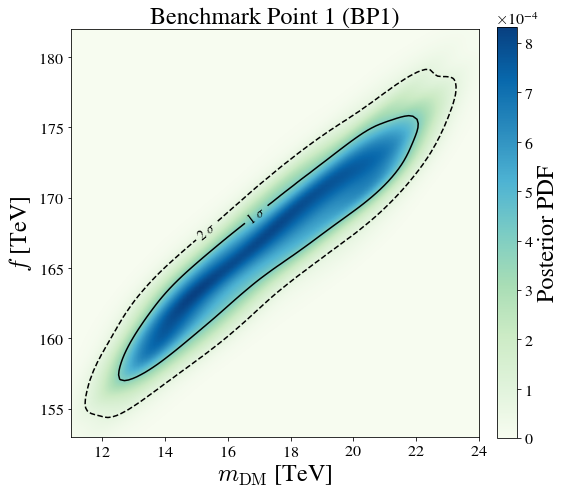

In [16]:
if PLOTRANGE == 'Default':
    # ULSNEST_test
    plotPDF(posteriorDict["X"], posteriorDict["Y"], posteriorDict["pdf"], 
            axisRange, posteriorDict["critDensity"], expBoundDict, posteriorPlotArgs)
elif PLOTRANGE == 'BP1':
    # ULSNEST_BP1
    plotPDF(posteriorDict["X"], posteriorDict["Y"], posteriorDict["pdf"], 
            axisRange, posteriorDict["critDensity"], {}, posteriorPlotArgs, plotName='paperPlots/BP1_Posterior.pdf')
elif PLOTRANGE == 'BP2':
    # ULSNEST_BP2
    plotPDF(posteriorDict["X"], posteriorDict["Y"], posteriorDict["pdf"], 
             axisRange, posteriorDict["critDensity"], {}, posteriorPlotArgs, plotName='paperPlots/BP2_Posterior.pdf')

## Plot the likelihood

The likelihood is the likelihood of $\theta$ having generated the data, $D$. In this case our $\theta$ are e.g. $m_\chi$ and $f_\Pi$. We plot a heatmap of $\mathcal{L}(D \mid \theta)$ with curves whose interior denotes the regions of parameter space which agree with experiments at the 1 and 2 $\sigma$ level. (Jessica: Check that the last part is statistically sound...)

In [17]:
#-- Set stylistic elements of plot --#
likelihoodPlotArgs = {'plotTitle': plotTitle,
                    'zAxisTitle': 'Likelihood PDF',
                    'xAxisTitle': r'$m_{\rm DM}$ [TeV]',
                    'yAxisTitle': r'$f$ [TeV]',
                    'LHC_frac': 0.1} # Fraction above ymin that "LHC bound" is printed

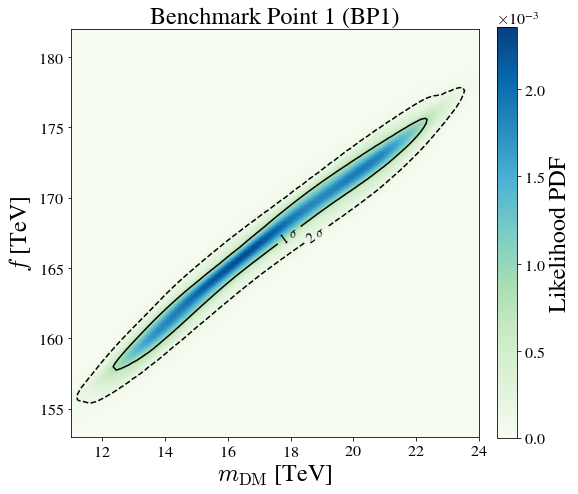

In [18]:
if PLOTRANGE == 'Default':
    # ULSNEST_test
    plotPDF(likelihoodDict["X"], likelihoodDict["Y"], likelihoodDict["pdf"], 
            axisRange, likelihoodDict["critDensity"], expBoundDict, likelihoodPlotArgs)
elif PLOTRANGE == 'BP1':
    # ULSNEST_BP1
    plotPDF(likelihoodDict["X"], likelihoodDict["Y"], likelihoodDict["pdf"], 
            axisRange, likelihoodDict["critDensity"], {}, likelihoodPlotArgs, plotName='paperPlots/BP1_Likelihood.pdf')
elif PLOTRANGE == 'BP2':
    # ULSNEST_BP2
    plotPDF(likelihoodDict["X"], likelihoodDict["Y"], likelihoodDict["pdf"], 
            axisRange, likelihoodDict["critDensity"], {}, likelihoodPlotArgs, plotName='paperPlots/BP2_Likelihood.pdf')

# Make plot of cross-section over same region

In [19]:
if PLOTRANGE == 'Default':
    plotTitle = ''
    plotName  = ''
    kwargs    = { "gs":0.8, "kappa":0.0, "asmall":0.625, "sQsq":0.3}
elif PLOTRANGE == 'BP1':
    plotTitle = 'Benchmark Point 1 (BP1)'
    plotName  = 'paperPlots/BP1_aeff.pdf'
    kwargs    = { "gs":0.8, "kappa":0.0, "asmall":0.625, "sQsq":0.3}
elif PLOTRANGE == 'BP2':
    plotTitle = 'Benchmark Point 2 (BP2)'
    plotName  = 'paperPlots/BP2_aeff.pdf'
    kwargs    = { "gs":0.1, "kappa":0.0, "asmall":0.1, "sQsq":0.01}

xmin, xmax, ymin, ymax = axisRange[0], axisRange[1], axisRange[2], axisRange[3]

In [20]:
#-- Make meshgrid --#
gMesh=10j
X, Y = np.mgrid[xmin:xmax:gMesh, ymin:ymax:gMesh] # gMesh x gMesh grid
positions = np.vstack([X.ravel(), Y.ravel()]).T

In [21]:
#-- Evaluate aeff on meshgrid --#
from m1_aeff import calcM1Aeff

m1List = []
aeffList = []
i = 0
imax = positions.shape[0]
n = int(imax/10.)
for mD, fpi in positions:
    
    if i % n == 0:
        print("Calculating data point %d out of %d"%(i,imax))
    
    if CASE ==4:
        kwargs["mD"]  = mD*1000  # Convert to GeV
        kwargs["fpi"] = fpi*1000 # Convert to GeV
    
    m1, aeff = calcM1Aeff(**kwargs)
    
    m1List.append(m1)
    aeffList.append(aeff.real)
    
    i = i+1

#-- Save results to dictionary --#
m1AeffDict = {}
m1AeffDict["mD"]   = X
m1AeffDict["fpi"]  = Y
m1AeffDict["m1"]   = np.reshape(np.array(m1List), X.shape ) 
m1AeffDict["aeff"] = np.reshape(np.array(aeffList), X.shape )

Calculating data point 0 out of 100
Calculating data point 10 out of 100
Calculating data point 20 out of 100
Calculating data point 30 out of 100
Calculating data point 40 out of 100
Calculating data point 50 out of 100
Calculating data point 60 out of 100
Calculating data point 70 out of 100
Calculating data point 80 out of 100
Calculating data point 90 out of 100


In [22]:
#-- Set stylistic elements of plot --#
aeffPlotArgs = {'plotTitle': plotTitle,
                  'zAxisTitle': r'$\sigma_{\rm eff}$ [GeV$^{-2}$]',
                  'xAxisTitle': r'$m_{\rm DM}$ [TeV]',
                  'yAxisTitle': r'$f$ [TeV]',
                  'cmap': 'magma',#'gnuplot'
                  'contourLineColor': 'white'}

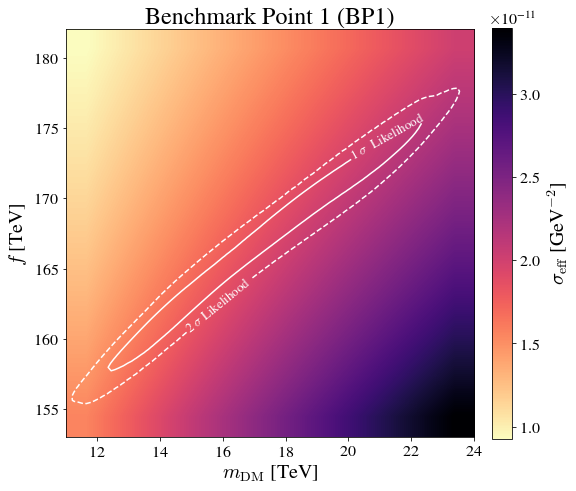

In [23]:
from plotUtils import plotAeff
plotAeff(m1AeffDict["mD"], m1AeffDict["fpi"], m1AeffDict["aeff"], axisRange, aeffPlotArgs, likelihoodDict, plotName=plotName)

In [24]:
# Check to make sure orientation is correct
if CASE == 4:
    kwargs["mD"]  = 24*1000  #GeV
    kwargs["fpi"] = 155*1000 #GeV
    
print(calcM1Aeff(**kwargs))

(2716978.901656356, (3.2669360485328806e-11+0j))


# Plot $m_1$ as well

In [25]:
#-- Set stylistic elements of plot --#
plotName = 'paperPlots/%s_m1.pdf'%PLOTRANGE
m1PlotArgs = {'plotTitle': plotTitle,
                  'zAxisTitle': r'$m_1$ [GeV]',
                  'xAxisTitle': r'$m_{\rm DM}$ [TeV]',
                  'yAxisTitle': r'$f$ [TeV]',
                  'cmap': 'magma',#'gnuplot'
                  'contourLineColor': 'white'}

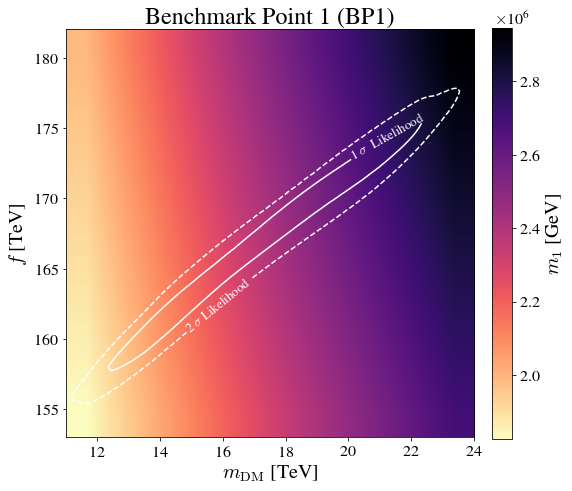

In [26]:
plotAeff(m1AeffDict["mD"], m1AeffDict["fpi"], m1AeffDict["m1"], axisRange, m1PlotArgs, likelihoodDict, plotName=plotName)

In [27]:
#-- Set stylistic elements of plot --#
plotName = 'paperPlots/%s_m1Inverse.pdf'%PLOTRANGE
m1PlotArgs = {'plotTitle': plotTitle,
                  'zAxisTitle': r'$(m_1)^{-1}$ [GeV]',
                  'xAxisTitle': r'$m_{\rm DM}$ [TeV]',
                  'yAxisTitle': r'$f$ [TeV]',
                  'cmap': 'magma',#'gnuplot'
                  'contourLineColor': 'white'}

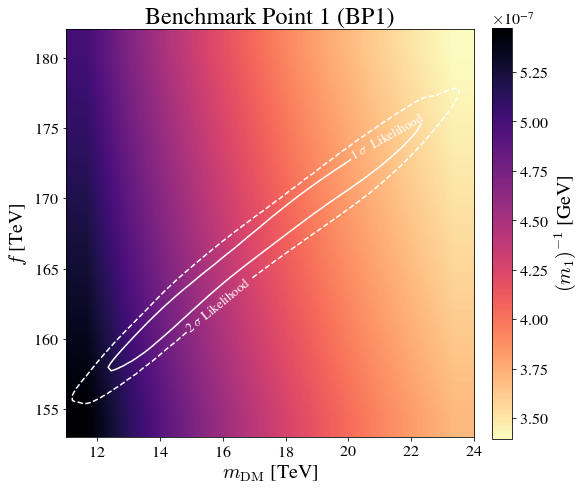

In [28]:
plotAeff(m1AeffDict["mD"], m1AeffDict["fpi"], 1./m1AeffDict["m1"], axisRange, m1PlotArgs, likelihoodDict, plotName=plotName)

# Probe functional dependence of $a_{eff}$

In [29]:
print(kwargs)

{'gs': 0.8, 'kappa': 0.0, 'asmall': 0.625, 'sQsq': 0.3, 'mD': 24000, 'fpi': 155000}


In [30]:
# Y and X are in TeV but aeff is in GeV. 1 TeV = 1000 GeV
Z = (m1AeffDict["aeff"]*((1000*Y)**3)/(1000*X))

# Calculate middle value
c = Z.min() + 0.5*(Z.max() - Z.min())
print(Z.min(), Z.max(), c)

# Normalize to this middle value
Z = Z*(1./c)
print(Z.min(), Z.max())

5.06887900723591 5.078469555496253 5.073674281366081
0.9990548715064774 1.0009451284935225


In [31]:
# Set c-value string
from plotUtils import sciNotationString
cValStr = sciNotationString(c)[1:-1]
print(cValStr)

if cValStr[-3:-1] == '00':
    cValStr = cValStr[0:4]

zAxisTitle = r'$(%s)^{-1}$ $(f^3/ m_{\rm DM})$ $\sigma_{\rm eff}$'%cValStr #$\frac{f^3 \sigma_{eff}}{m_{DM}}$'
print(zAxisTitle)

5.07 \times 10^{+00}
$(5.07)^{-1}$ $(f^3/ m_{\rm DM})$ $\sigma_{\rm eff}$


In [32]:
#-- Set stylistic elements of plot --#
plotName = 'paperPlots/%s_ratio.pdf'%PLOTRANGE

if PLOTRANGE == 'BP1' or PLOTRANGE == 'BP2':
    ratioPlotArgs = {'plotTitle': plotTitle,
                      'zAxisTitle': r'%s'%zAxisTitle,
                      'xAxisTitle': r'$m_{\rm DM}$ [TeV]',
                      'yAxisTitle': r'$f$ [TeV]',
                      'cmap': 'magma',#'gnuplot'
                      'contourLineColor': 'white'}
else:
    ratioPlotArgs = {'plotTitle': plotTitle,
                      'zAxisTitle': r'$\frac{f^3 \sigma_{\rm eff}}{m_{\rm DM}}$',
                      'xAxisTitle': r'$m_{\rm DM}$ [TeV]',
                      'yAxisTitle': r'$f$ [TeV]',
                      'cmap': 'magma',#'gnuplot'
                      'contourLineColor': 'white'}

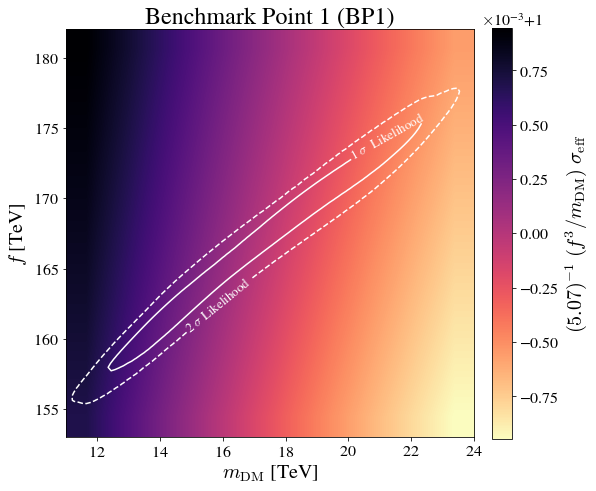

In [33]:
plotAeff(m1AeffDict["mD"], m1AeffDict["fpi"], Z, axisRange, ratioPlotArgs, likelihoodDict, plotName=plotName)